In [197]:
#Importing the required libraries
from silo_to_yt import make_snapshots, get_ds
import yt
import numpy as np
import os
from make_movies import make_movies

yt.set_log_level("ERROR")

cwd = os.getcwd()

In [198]:
data_path = "/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064/"

print(os.getcwd())
# Get the list of silo files
evolution = make_snapshots(data_path)

print(os.getcwd())
# Changing back to the original directory
os.chdir(cwd)

print(os.getcwd())

/net/maedoc.ap.dias.ie/maedoc/home_cr/visitor_ap4/code/project/scripts/yt_folder
WR140_hydro_cool_d3l6n064
Simulation Info: 6 levels
Shape of evolution array: (423, 6)
/net/aramis.ap.dias.ie/aramis/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064
/net/maedoc.ap.dias.ie/maedoc/home_cr/visitor_ap4/code/project/scripts/yt_folder


In [199]:
ds = get_ds(evolution[0])

DBOpen: File not found or invalid permissions: WR140_hydro_cool_d3l6n064_level00_0000.00000000.silo


TypeError: File could not be opened

In [178]:
def get_ts(**kwargs):

    os.chdir(data_path)
    ds_list = []

    start = kwargs.get('start', 1)
    end = kwargs.get('end', 10)
    step = kwargs.get('step', 1)

    # Load the desired snapshots
    for i in range(start, end, step):
        ds_list.append(get_ds(evolution[i]))

    print("Number of datasets: ", len(ds_list))
    os.chdir(cwd)
    # Create time series object
    return yt.DatasetSeries(ds_list)
    del ds_list

In [179]:
ts = get_ts(start=100, end=125, step=5)

Number of datasets:  5


In [173]:
# Get list of fields
fields = ts[0].field_list
print("\nList of fields: ", fields)



List of fields:  [('gas', 'density'), ('gas', 'temperature'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')]


In [5]:
img_dir = os.path.join(cwd, "yt_images/VolumeRenders")
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
    print("Created images directory:{} ".format(img_dir))
else:
    print("Images directory already exists")

Images directory already exists


# Volume Rendering

In [29]:
# Creating volume renderings at each time step in ts
for i in range(len(ts)):
    sc = yt.create_scene(ts[i])
    
    # identifying the source
    source = sc[0]
    source.set_field('density')
    source.set_log(True)

    # building transfer function
    bounds = (1e-18, 1e-12)
    tf = yt.ColorTransferFunction(x_bounds=np.log10(bounds))
    tf.add_layers(5, w=0.005, colormap='viridis')
    
    source.tfh.tf = tf
    source.tfh.bounds = bounds
    
    cam = sc.camera
    cam.zoom(2)
    # cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 1, 0])

    sc.save(os.path.join(img_dir, f"wr140_hyd_n064_{i+1}"), sigma_clip=6.0)
    
    del sc, tf, cam, source

In [30]:
make_movies(img_dir, img_dir, "wr140_hyd_n064_temp3.mp4")

Moviepy - Building video /net/maedoc.ap.dias.ie/maedoc/home_cr/visitor_ap4/code/project/scripts/yt_folder/yt_images/VolumeRenders/wr140_hyd_n064_temp3.mp4.
Moviepy - Writing video /net/maedoc.ap.dias.ie/maedoc/home_cr/visitor_ap4/code/project/scripts/yt_folder/yt_images/VolumeRenders/wr140_hyd_n064_temp3.mp4



Moviepy - Done !
Moviepy - video ready /net/maedoc.ap.dias.ie/maedoc/home_cr/visitor_ap4/code/project/scripts/yt_folder/yt_images/VolumeRenders/wr140_hyd_n064_temp3.mp4


In [31]:
ds = ts[0]


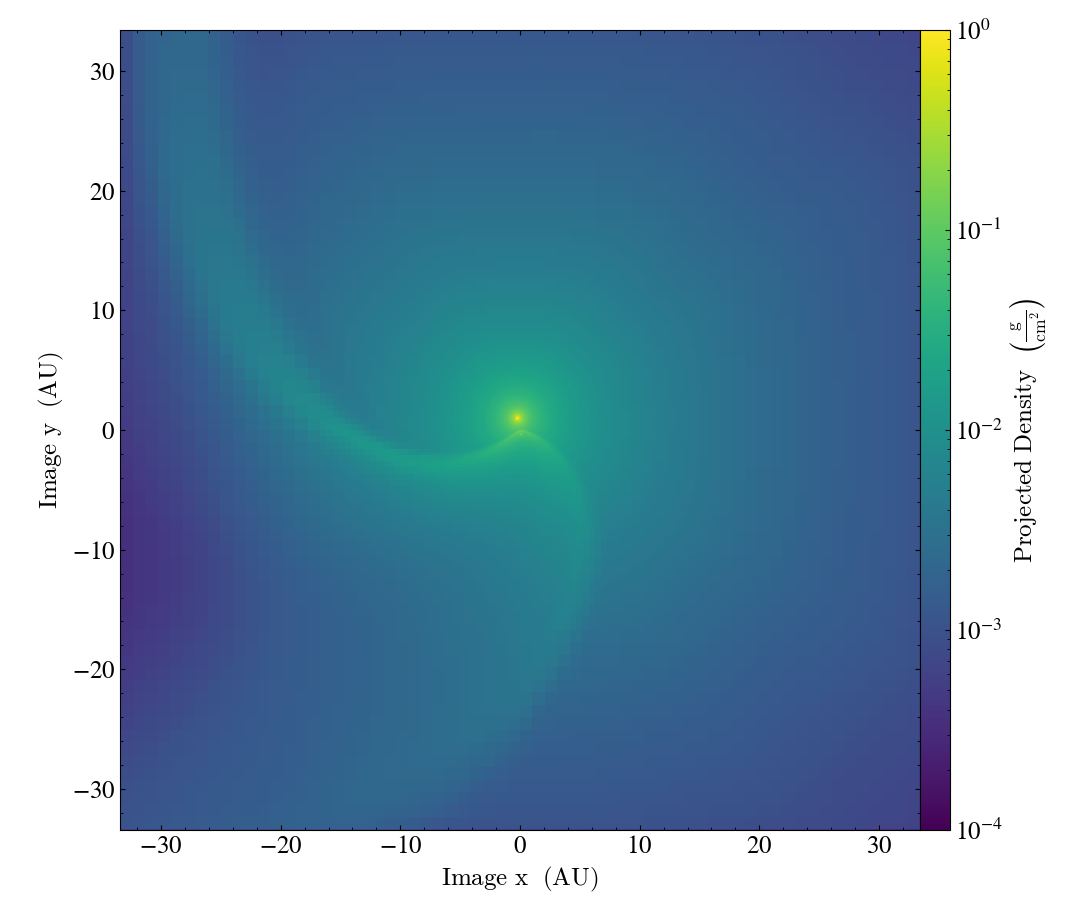

In [195]:
prj = yt.ProjectionPlot(ts[2], 
                                center=[0.5, 0.5, 0.5], 
                                fields="density", width=[1,1,1], 
                                method="integrate", normal=[-1,0,0.00001] ,
                                north_vector=[0,0,1],
                                # weight_field="z"
                                # buff_size=(100,100)
                                )

prj.set_cmap("density", "viridis")
prj.set_zlim("density", 1e-4, 1)
prj.show()



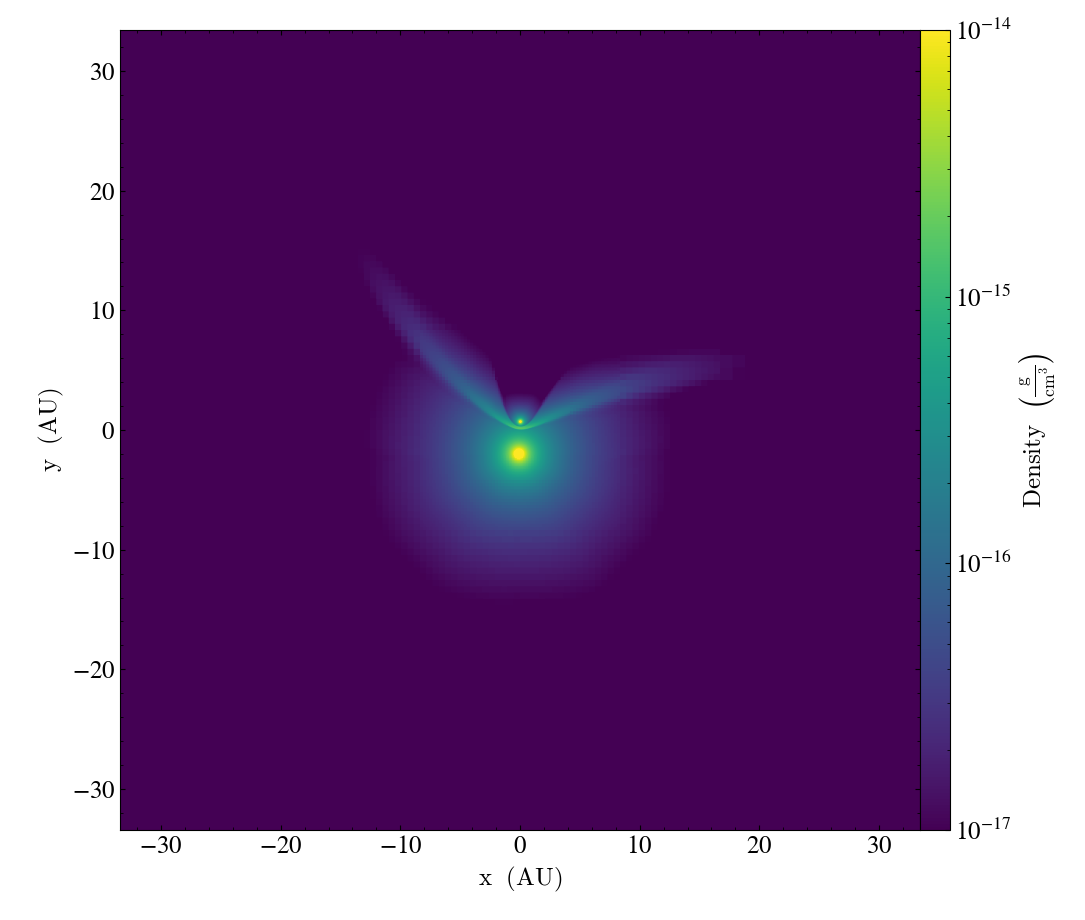

In [183]:
slc = yt.SlicePlot(ts[0], "z",fields="density", center="c")
slc.set_cmap("density", "viridis")
slc.set_zlim("density", 1e-17, 1e-14)
slc.show()

# Streamlines: Tracking the Trajectories of Tracers in your Data

Streamlining: 100%|██████████| 100/100 [00:01<00:00, 63.30it/s]


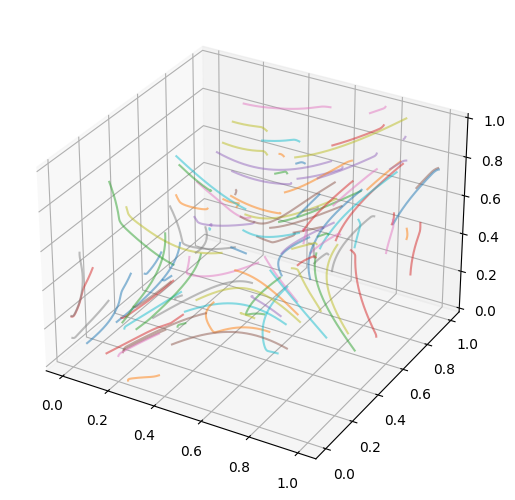

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import yt
from yt.units import AU
from yt.visualization.api import Streamlines

ds = ts[5]

c = ds.domain_center
N = 100
scale = ds.domain_width[0]
pos_dx = np.random.random((N, 3)) * scale - scale / 2.0
pos = c + pos_dx

# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = Streamlines(
    ds,
    pos,
    ("gas", "velocity_x"),
    ("gas", "velocity_y"),
    ("gas", "velocity_z"),
    length=30.0 * AU,
    get_magnitude=True,
)
streamlines.integrate_through_volume()

# Create a 3D plot, trace the streamlines through the 3D volume of the plot
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    ax.plot3D(stream[:, 0], stream[:, 1], stream[:, 2], alpha=0.5)

# Save the plot to disk.
plt.savefig("streamlines.png")




In [131]:
# pws = sl.to_pw(fields=[("gas", "density")])
# pws.show()

# 1D Profile Plots


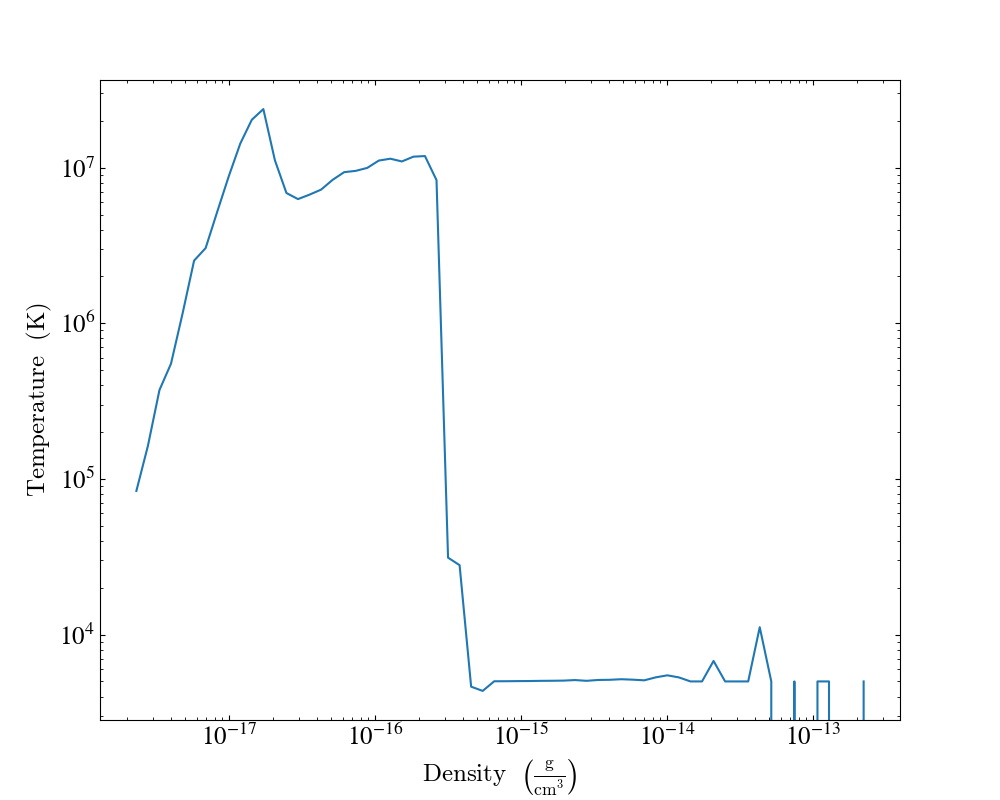

In [151]:
ds = ts[0]


mysphere = ds.sphere([0.5,0.5,0.5], (0.1, "code_length"))
plot = yt.ProfilePlot(mysphere, "density", "temperature")
plot.show()